In [10]:
import re

In [11]:
import numpy as np
import pandas as pd

In [12]:
# deactivate false positive warning
pd.options.mode.chained_assignment = None

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
results = [
    np.arange(5),
    np.arange(5),
]

In [15]:
np.vstack(results).T

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4]])

# Read Data

In [16]:
from utils import get_data

In [17]:
df = get_data()

# Features

## owl features

In [18]:
owl_features = pd.read_csv('/tmp/owl.csv', index_col=0)

## text features

In [19]:
text_features = pd.read_csv('/tmp/text.csv', index_col=0)

## attribute features

In [20]:
attribute_features = pd.read_csv('/tmp/attribute.csv', index_col=0)

## categorial features

In [21]:
categorial_features = pd.read_csv('/tmp/categorial.csv', index_col=0)

### difflib

In [22]:
from difflib import SequenceMatcher as seq_matcher

In [23]:
#difflib_features = pd.DataFrame(index=df.index)

In [24]:
#%%time
#seq_distances = []
#for i, (a, b) in enumerate(zip(df.search_term, df.product_title)):
#    seq_distances.append(seq_matcher(None, a, b).ratio())
#    if i % 10000 == 0:
#        print(i)

In [25]:
#difflib_features['seq_match_ratio'] = 1.0 - np.array(seq_distances)

### id features

In [26]:
from scipy.sparse import hstack

In [27]:
import pickle

In [28]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer(sparse_output=True)

In [29]:
query_features = lb.fit_transform(categorial_features.query_id)

In [30]:
product_uid_features = lb.fit_transform(categorial_features.product_uid)

In [31]:
color_features = lb.fit_transform(categorial_features.color_id)

In [32]:
#len(set(categorial_features.product_uid))

### pure text

In [33]:
from sklearn.decomposition import TruncatedSVD

In [34]:
from text import StemmedTfidfVectorizer

In [35]:
#%%time
#pure_text = StemmedTfidfVectorizer().fit_transform(
#    df.search_term + '\t' + df.product_title + '\t' + df.product_description)
#pure_text = TruncatedSVD(n_components=200, n_iter=15).fit_transform(pure_text)

In [36]:
%%time
pure_search_term = StemmedTfidfVectorizer().fit_transform(df.search_term)

CPU times: user 12.8 s, sys: 63.3 ms, total: 12.9 s
Wall time: 17.1 s


In [37]:
%%time
pure_product_title = StemmedTfidfVectorizer().fit_transform(df.product_title)

CPU times: user 40.2 s, sys: 267 ms, total: 40.5 s
Wall time: 53.6 s


In [98]:
%%time
svd_search_term = TruncatedSVD(n_components=150, n_iter=15).fit_transform(pure_search_term)

CPU times: user 15.2 s, sys: 2.93 s, total: 18.2 s
Wall time: 10.6 s


In [99]:
%%time
svd_product_title = TruncatedSVD(n_components=150, n_iter=15).fit_transform(pure_product_title)

CPU times: user 22.4 s, sys: 3.03 s, total: 25.4 s
Wall time: 17.4 s


In [40]:
%%time
pure_product_desc = StemmedTfidfVectorizer().fit_transform(df.product_description)
svd_product_desc = TruncatedSVD(n_components=200, n_iter=15).fit_transform(pure_product_desc)

CPU times: user 9min 51s, sys: 11.6 s, total: 10min 3s
Wall time: 10min 32s


In [41]:
#%%time
#pure_product_attr = StemmedTfidfVectorizer().fit_transform(df.attr_texts)

In [42]:
def svd_cosine_similarity_row_wise(a, b):
  result = np.empty(a.shape[0])
  for i in range(a.shape[0]):
      result[i] = a[i].dot(b[i].T)
  return result

In [43]:
svd_cosine = pd.DataFrame(index=df.index)

In [45]:
%%time
#svd_cosine['svd_query_title'] = svd_cosine_similarity_row_wise(pure_search_term, pure_product_title)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [46]:
%%time
#svd_cosine['svd_query_description'] = svd_cosine_similarity_row_wise(pure_search_term, pure_product_desc)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [47]:
#svd_cosine['svd_golden'] = svd_cosine.svd_query_title - svd_cosine.svd_query_description

### counts

In [48]:
new_counts = pd.DataFrame(index=df.index)

In [49]:
def get_digit_quote(column):
    return column.apply(lambda x: float(len(''.join([c for c in x if c.isdigit()])))) \
        / column.str.len()

In [50]:
def get_alpha_quote(column):
    return column.apply(lambda x: float(len(''.join([c for c in x if c.isalpha()])))) \
        / column.str.len()

In [51]:
def get_upper_quote(column):
    return (column.apply(lambda x: float(len(''.join([c for c in x if c.isupper()])))) \
        / column.str.len()).fillna(value=0)

In [52]:
%%time
new_counts['query_digit_quote'] = get_digit_quote(
    df.search_term.apply(lambda x: ''.join([c for c in str(x).lower() if c.isalnum()])))
new_counts['title_digit_quote'] = get_digit_quote(
    df.product_title.apply(lambda x: ''.join([c for c in str(x).lower() if c.isalnum()])))
new_counts['desc_digit_quote'] = get_digit_quote(
    df.product_description.apply(lambda x: ''.join([c for c in str(x).lower() if c.isalnum()])))

CPU times: user 42.4 s, sys: 231 ms, total: 42.6 s
Wall time: 42.7 s


In [53]:
%%time
new_counts['query_alpha_quote'] = get_alpha_quote(
    df.search_term.apply(lambda x: ''.join([c for c in str(x).lower() if c.isalnum()])))
new_counts['title_alpha_quote'] = get_alpha_quote(
    df.product_title.apply(lambda x: ''.join([c for c in str(x).lower() if c.isalnum()])))
new_counts['desc_alpha_quote'] = get_alpha_quote(
    df.product_description.apply(lambda x: ''.join([c for c in str(x).lower() if c.isalnum()])))

CPU times: user 49.1 s, sys: 175 ms, total: 49.3 s
Wall time: 49.4 s


In [54]:
%%time
new_counts['query_upper_quote'] = get_upper_quote(
    df.search_term.apply(lambda x: ''.join([c for c in str(x) if c.isalpha()])))
new_counts['title_upper_quote'] = get_upper_quote(
    df.product_title.apply(lambda x: ''.join([c for c in str(x) if c.isalpha()])))
new_counts['desc_upper_quote'] = get_upper_quote(
    df.product_description.apply(lambda x: ''.join([c for c in str(x) if c.isalpha()])))

CPU times: user 43.2 s, sys: 225 ms, total: 43.5 s
Wall time: 43.6 s


In [55]:
df['query_id'] = categorial_features.query_id

In [56]:
mean_relevance = pd.DataFrame(index=df.index)

In [57]:
mean_relevance['mean_relevance'] = df.product_uid.apply(lambda x: 2.45 if x < 164250 else 2.225)

In [58]:
mean_relevance['product_uid'] = df.product_uid

In [59]:
mean_relevance.mean_relevance.value_counts()

2.450    163994
2.225     76707
Name: mean_relevance, dtype: int64

In [60]:
#mean_relevance

## dice

In [61]:
def try_divide(x, y, val=0.0):
    """
        Try to divide two numbers
    """
    if y != 0.0:
        val = float(x) / y
    return val

In [62]:
def DiceDist(A, B):
    A, B = set(A), set(B)
    intersect = len(A.intersection(B))
    union = len(A) + len(B)
    d = try_divide(2*intersect, union)
    return d

In [63]:
def pairwise_dice_dist(A, B):
    d = np.zeros((A.shape[0], B.shape[0]), dtype=float)
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            d[i,j] = DiceDist(A[i], B[j])
    return d

In [64]:
svd_search_term.shape

(240701, 250)

In [65]:
svd_product_title.shape

(240701, 250)

## concat features

In [66]:
from sklearn.preprocessing import scale

In [77]:
#sparse_features = scale(pure_search_term, with_mean=False, axis=0)
#sparse_features = hstack((pure_search_term, pure_product_title))#, pure_product_desc))
sparse_features = hstack((query_features, product_uid_features, color_features))
#sparse_features = hstack((query_features, product_uid_features, color_features, # benchmark
#                          svd_search_term, svd_product_title))
#sparse_features = np.hstack((svd_search_term, svd_product_title))
#sparse_features = hstack((query_features, product_uid_features, color_features,
#                          pure_text))

In [78]:
sparse_features

<240701x39492 sparse matrix of type '<class 'numpy.int64'>'
	with 722103 stored elements in COOrdinate format>

In [79]:
pickle.dump(sparse_features, open('/tmp/sparse_features.pickle', 'wb'), protocol=-1)

In [80]:
#svd_sparse = TruncatedSVD(n_components=100, n_iter=15).fit_transform(sparse_features)

In [100]:
svd_features = np.hstack((svd_search_term, svd_product_title))#, svd_product_desc))#, svd_sparse))

In [101]:
pickle.dump(svd_features, open('/tmp/svd_features.pickle', 'wb'), protocol=-1)

In [83]:
features = pd.concat([df[['id', 'relevance']], text_features, owl_features,
                      attribute_features, categorial_features, new_counts, mean_relevance], axis=1) # benchmark
#features = pd.concat([df[['id', 'relevance']], text_features, owl_features,
#                      attribute_features, categorial_features, new_counts, mean_relevance], axis=1)
#features = pd.concat([df[['id', 'relevance']], text_features,
#                      attribute_features, categorial_features, new_counts,
#                      mean_relevance], axis=1)

In [74]:
%%time
pickle.dump(features, open('/tmp/features.pickle', 'wb'), protocol=-1)
#features.to_csv('/tmp/features.csv')

CPU times: user 95.6 ms, sys: 225 ms, total: 321 ms
Wall time: 470 ms


### cleanup

In [150]:
pd.set_option('max_colwidth', 200)

In [153]:
df[['product_uid', 'relevance', 'search_term', 'product_title']]

,product_uid,relevance,search_term,product_title
0,100001,3.00,angle bracket,Simpson Strong-Tie 12-Gauge Angle
1,100002,3.00,deck over,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating
2,100005,2.33,rain shower head,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included)
3,100005,2.67,shower only faucet,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included)
4,100006,3.00,convection otr,Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking
5,100006,2.67,microwave over stove,Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking
6,100006,3.00,microwaves,Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking
7,100007,2.67,emergency light,Lithonia Lighting Quantum 2-Light Black LED Emergency Fixture Unit
8,100009,3.00,mdf 3/4,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Fluted Casing
9,100010,2.67,steele stake,Valley View Industries Metal Stakes (4-Pack)


## memory

In [66]:
features.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240701 entries, 0 to 240700
Data columns (total 49 columns):
id                                 240701 non-null int64
relevance                          74008 non-null float64
two_word_query                     240701 non-null int64
query_in_title                     240701 non-null float64
search_text_len_char               240701 non-null int64
search_text_len_word               240701 non-null int64
brand_text_len_char                240701 non-null int64
brand_text_len_word                240701 non-null int64
title_text_len_char                240701 non-null int64
title_text_len_word                240701 non-null int64
desc_text_len_char                 240701 non-null int64
desc_text_len_word                 240701 non-null int64
attr_text_len_char                 240701 non-null int64
attr_text_len_word                 240701 non-null int64
all_text_len_char                  240701 non-null int64
all_text_len_word              

In [17]:
features.shape

(240701, 68)

# training data

In [20]:
num_train = 74008

In [21]:
df_train = df.iloc[:num_train]
df_test = df.iloc[num_train:]
id_test = df_test['id']
y_train = df_train['relevance'].values
df_train.relevance.value_counts()

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
Name: relevance, dtype: int64

In [253]:
train_search_terms = set(df_train.search_term)

In [254]:
test_search_terms = set(df_test.search_term)

In [255]:
len(train_search_terms.intersection(test_search_terms))

9621

# Visualization of Features

## Relevance Distribution

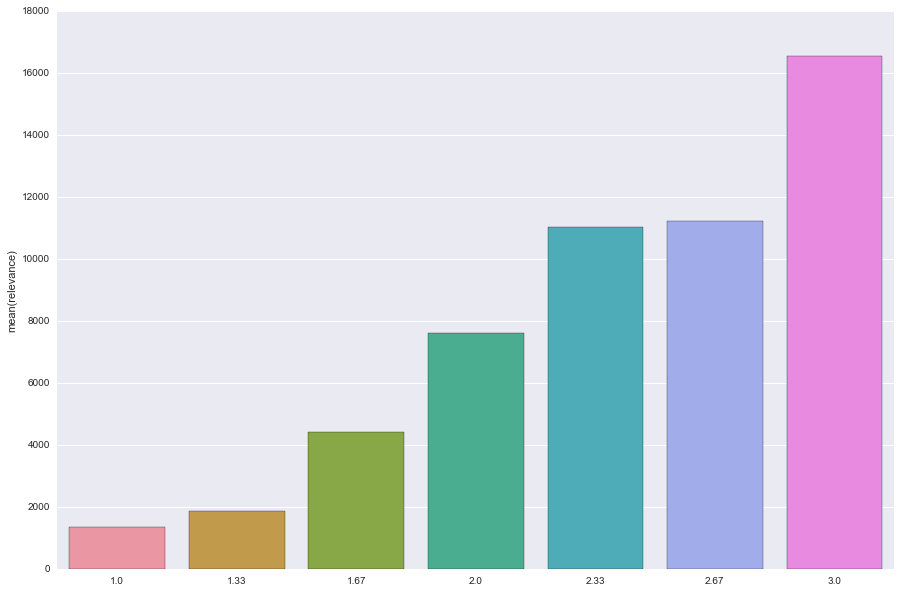

In [38]:
plt.figure(figsize=(15, 10))
low_product_ids = df[df.product_uid < 164250].relevance.value_counts()
sns.barplot(x=low_product_ids.index, y=low_product_ids)

In [46]:
lower_dist = dict((df[df.product_uid < 164250].relevance.value_counts() / df[(df.relevance > 0) & (df.product_uid < 164250)].shape[0]))

In [51]:
lower_dist

{1.0: 0.024928748565717883,
 1.3300000000000001: 0.034515305178221121,
 1.6699999999999999: 0.081837361661176292,
 2.0: 0.14098530554835845,
 2.3300000000000001: 0.2038346226450013,
 2.6699999999999999: 0.20785061257726617,
 3.0: 0.30604804382425882}

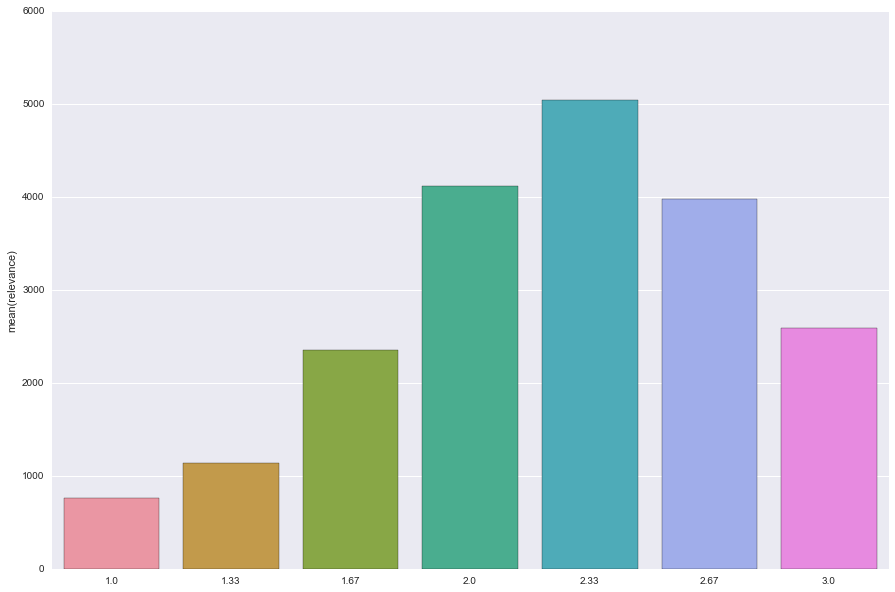

In [39]:
plt.figure(figsize=(15, 10))
high_product_ids = df[df.product_uid > 164250].relevance.value_counts()
sns.barplot(x=high_product_ids.index, y=high_product_ids)

In [47]:
upper_dist = dict(df[df.product_uid > 164250].relevance.value_counts() / df[(df.relevance > 0) & (df.product_uid > 164250)].shape[0])

In [52]:
upper_dist

{1.0: 0.037949334134374686,
 1.3300000000000001: 0.057124261540002004,
 1.6699999999999999: 0.11805346951036347,
 2.0: 0.20586762791629118,
 2.3300000000000001: 0.25262841694202465,
 2.6699999999999999: 0.19880845098628216,
 3.0: 0.12956843897066186}

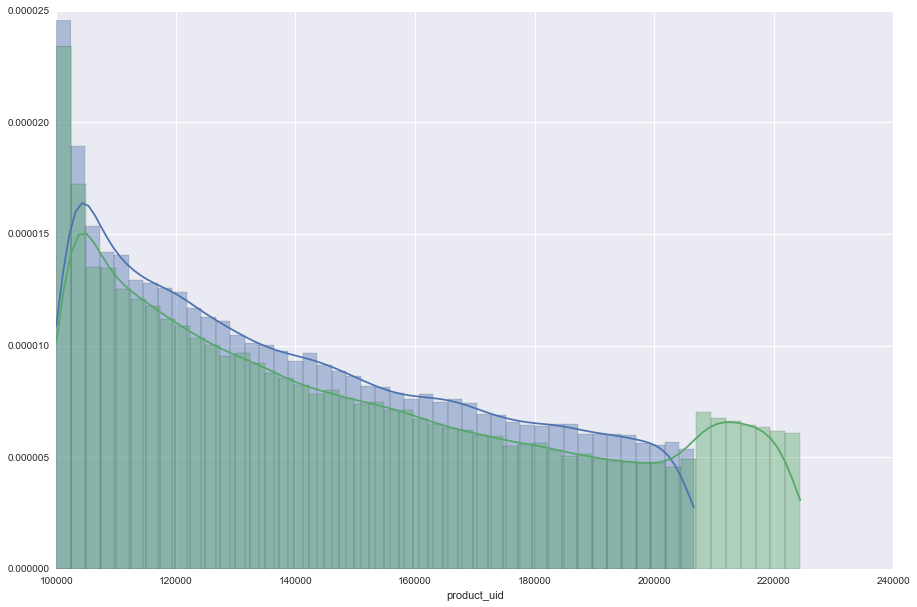

In [99]:
plt.figure(figsize=(15, 10))
sns.distplot(df[df.relevance > 0].product_uid)
sns.distplot(df[df.relevance.isnull()].product_uid)

In [193]:
products = df_train.groupby('product_uid')['relevance'].mean()

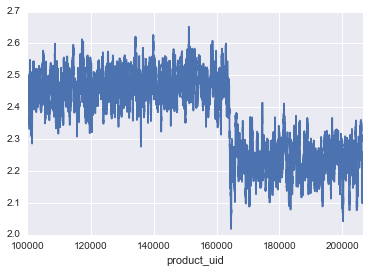

In [197]:
products.rolling(100).mean().plot()

In [207]:
products.index

Int64Index([100001, 100002, 100005, 100006, 100007, 100009, 100010, 100011,
            100012, 100013,
            ...
            206621, 206627, 206631, 206632, 206637, 206638, 206639, 206641,
            206648, 206650],
           dtype='int64', name='product_uid', length=54635)

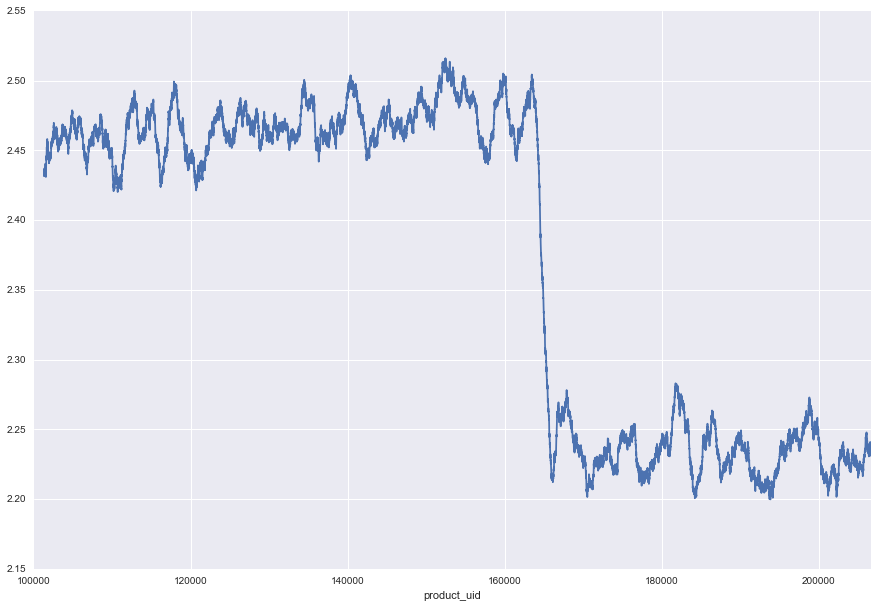

In [22]:
plt.figure(figsize=(15, 10))
products = df_train.groupby('product_uid')['relevance'].mean()
x = products.rolling(1000).mean().plot()

/Users/jochen/miniconda3/envs/homedepot/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


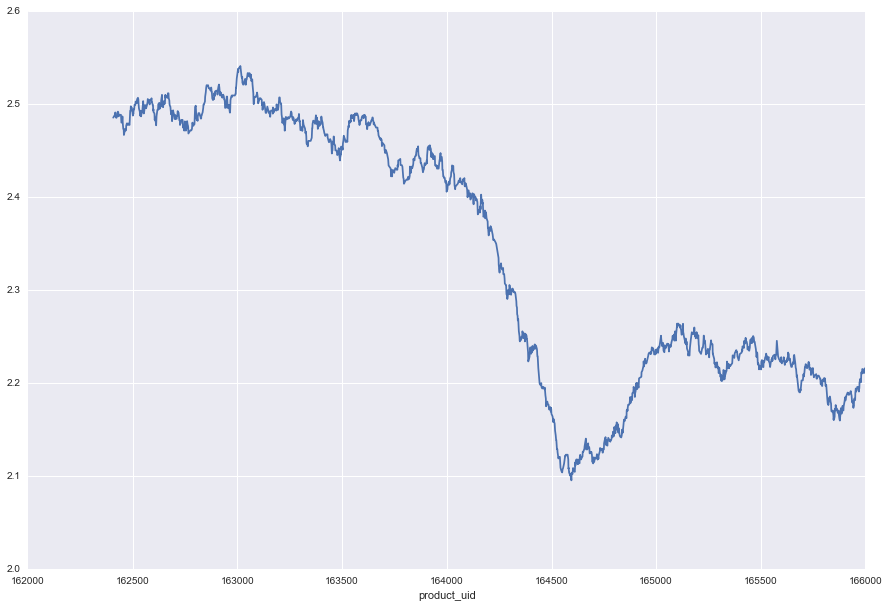

In [32]:
plt.figure(figsize=(15, 10))
products = df_train[(df.product_uid > 162000) & (df.product_uid < 166000)].groupby('product_uid')['relevance'].mean()
x = products.rolling(200).mean().plot()

In [181]:
df_train[df]

NameError: name 'df_train' is not defined

In [33]:
df_train.shape

(74008, 9)

In [177]:
foo = df.reindex(foo.product_uid)

In [179]:
foo

,id,product_title,product_uid,relevance,search_term,product_description,attr_count,attr_texts,brand,query_id,mean_relevance
product_uid,,,,,,,,,,,
100001,38448,Jeff Lewis Linus Grey 8 ft. x 10 ft. Area Rug,109062,NaN,grey rug,"Thin lines cross paths to create a clean, mode...",0,,,0,NaN
100002,38450,American Standard Studio EcoSilent 5 ft. x 36 ...,109063,NaN,5ft by 36 inches whirlpool tubs,"Soak up the bold, clean lines. This minimalist...",0,,,0,NaN
100005,38455,Wyndham Collection Amare 72 in. Double Vanity ...,109065,NaN,aqua glass,Modern clean lines and a truly elegant design ...,57,Yes\t0\tIvory\tBeige/bisque\t5\t16\tMarble\t18...,Wyndham Collection,6826,NaN
100005,38455,Wyndham Collection Amare 72 in. Double Vanity ...,109065,NaN,aqua glass,Modern clean lines and a truly elegant design ...,57,Yes\t0\tIvory\tBeige/bisque\t5\t16\tMarble\t18...,Wyndham Collection,6826,NaN
100006,38457,Emsco 16 in. x 16 in. Plastic Deep Red Brick P...,109067,NaN,16x8 inch patio stones red,Emsco Group Outdoor's heavy duty Brick Pattern...,27,192 in\t1 in\t192 in\tNo\tDeep red brick color...,Emsco,0,NaN
100006,38457,Emsco 16 in. x 16 in. Plastic Deep Red Brick P...,109067,NaN,16x8 inch patio stones red,Emsco Group Outdoor's heavy duty Brick Pattern...,27,192 in\t1 in\t192 in\tNo\tDeep red brick color...,Emsco,0,NaN
100006,38457,Emsco 16 in. x 16 in. Plastic Deep Red Brick P...,109067,NaN,16x8 inch patio stones red,Emsco Group Outdoor's heavy duty Brick Pattern...,27,192 in\t1 in\t192 in\tNo\tDeep red brick color...,Emsco,0,NaN
100007,38458,Emsco 16 in. x 16 in. Plastic Deep Red Brick P...,109067,NaN,brick patio,Emsco Group Outdoor's heavy duty Brick Pattern...,27,192 in\t1 in\t192 in\tNo\tDeep red brick color...,Emsco,0,NaN
100009,38461,Emsco 16 in. x 16 in. Plastic Deep Red Brick P...,109067,NaN,patio steps,Emsco Group Outdoor's heavy duty Brick Pattern...,27,192 in\t1 in\t192 in\tNo\tDeep red brick color...,Emsco,0,NaN


In [157]:
#plt.figure(figsize=(15, 10))
foo[foo.relevance > 0].relevance
#plt.plot(foo.product_uid, df.relevance.set_index('product_uid').rolling(window=1000).mean())

Series([], Name: relevance, dtype: float64)

## cosine distance

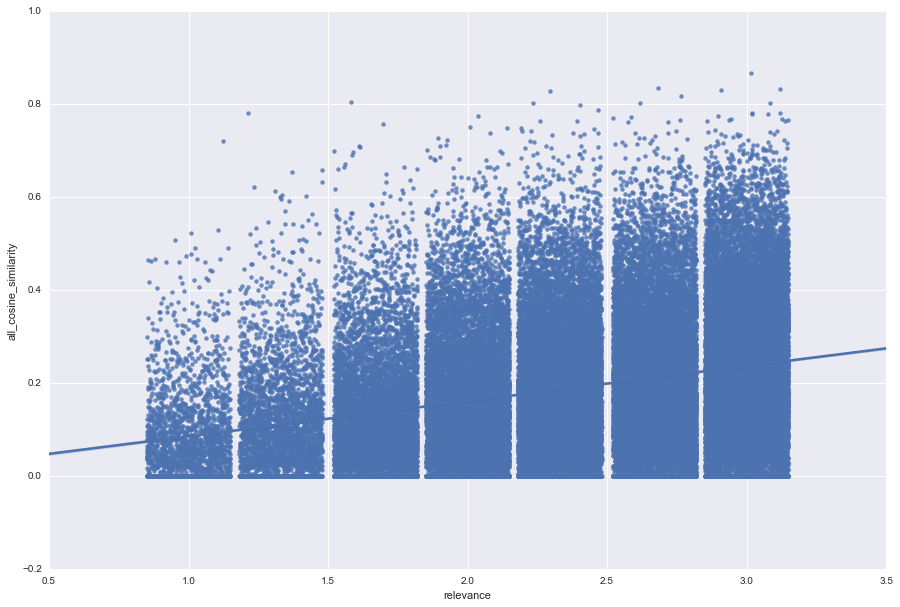

In [134]:
plt.figure(figsize=(15, 10))
sns.regplot(x="relevance", y="all_cosine_similarity", data=df_train, x_jitter=.15);

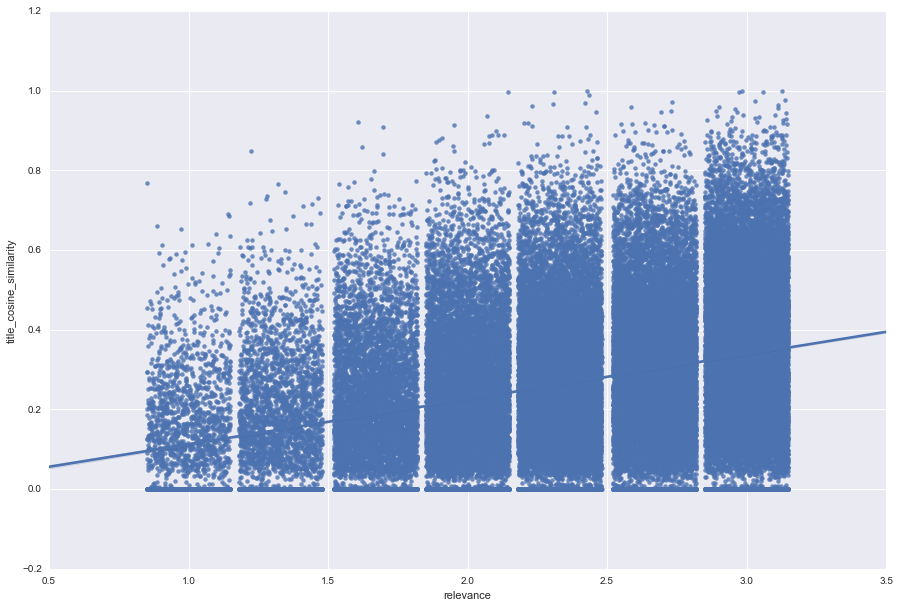

In [135]:
plt.figure(figsize=(15, 10))
sns.regplot(x="relevance", y="title_cosine_similarity", data=df_train, x_jitter=.15);

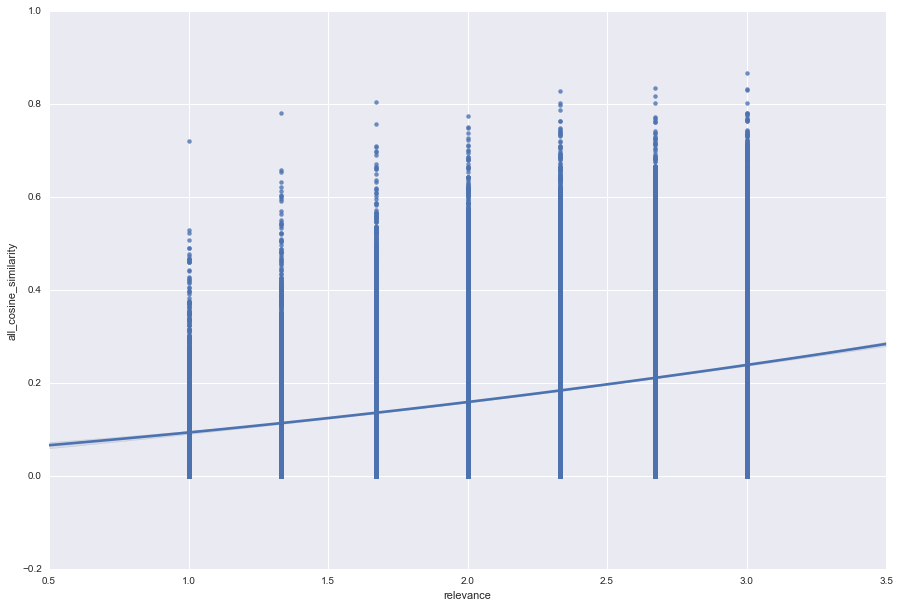

In [136]:
plt.figure(figsize=(15, 10))
sns.regplot(x="relevance", y="all_cosine_similarity", data=df_train, order=2);

In [137]:
#plt.figure(figsize=(15, 10))
#sns.lmplot(x="relevance", y="cosine_similarity", data=df_train, x_estimator=np.mean, order=2);

## jaccard similarity

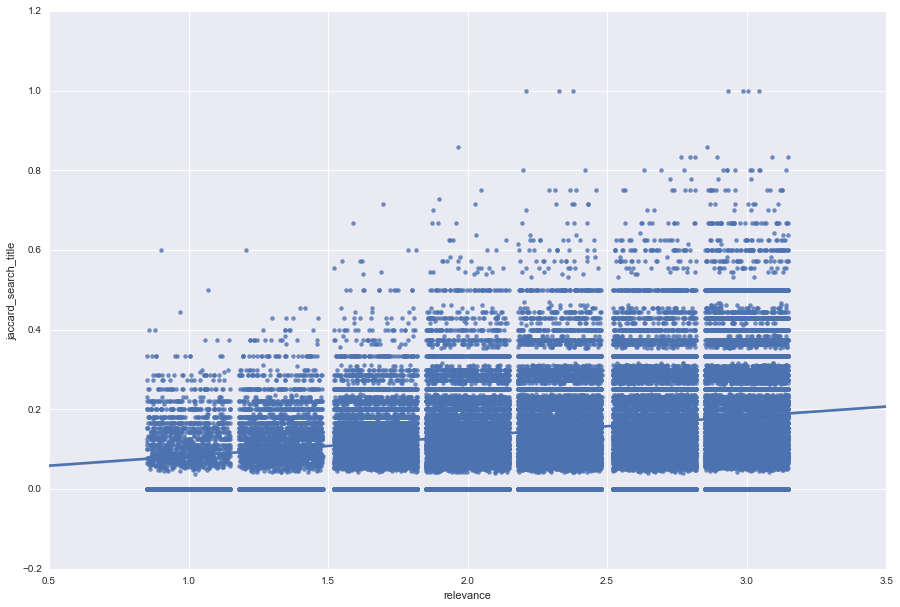

In [138]:
plt.figure(figsize=(15, 10))
sns.regplot(x="relevance", y="jaccard_search_title", data=df_train, x_jitter=.15);

## attribute count

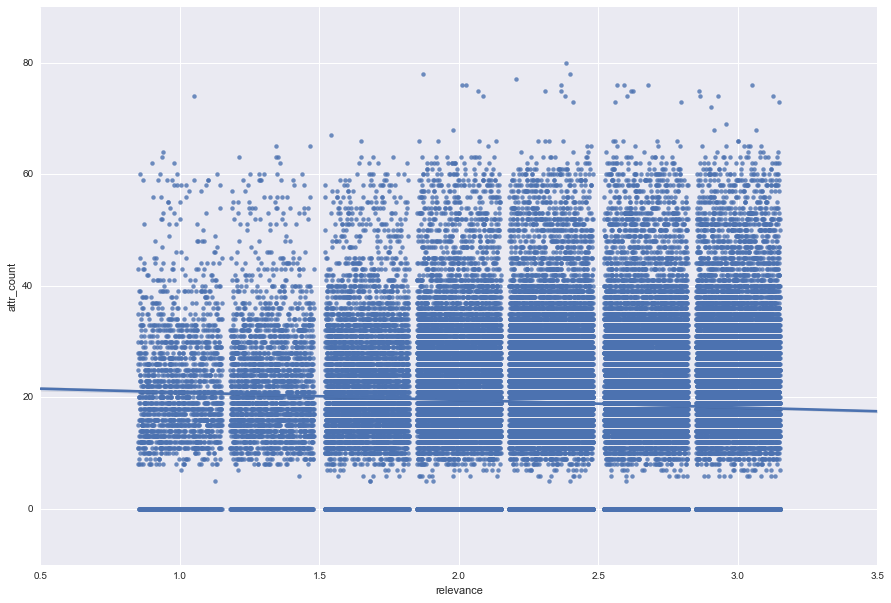

In [139]:
plt.figure(figsize=(15, 10))
sns.regplot(x="relevance", y="attr_count", data=df_train, x_jitter=.15);

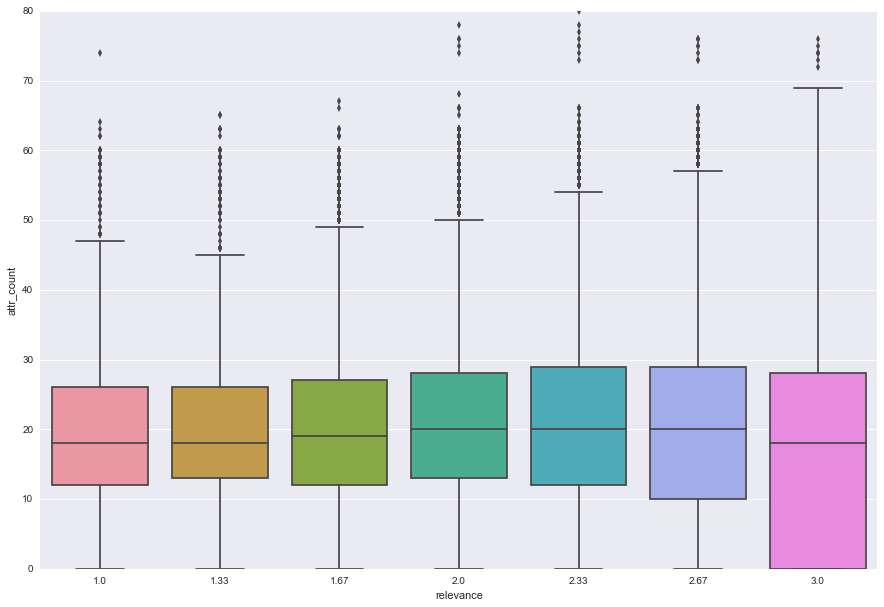

In [251]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='relevance', y='attr_count', data=df_train)

## product frequency

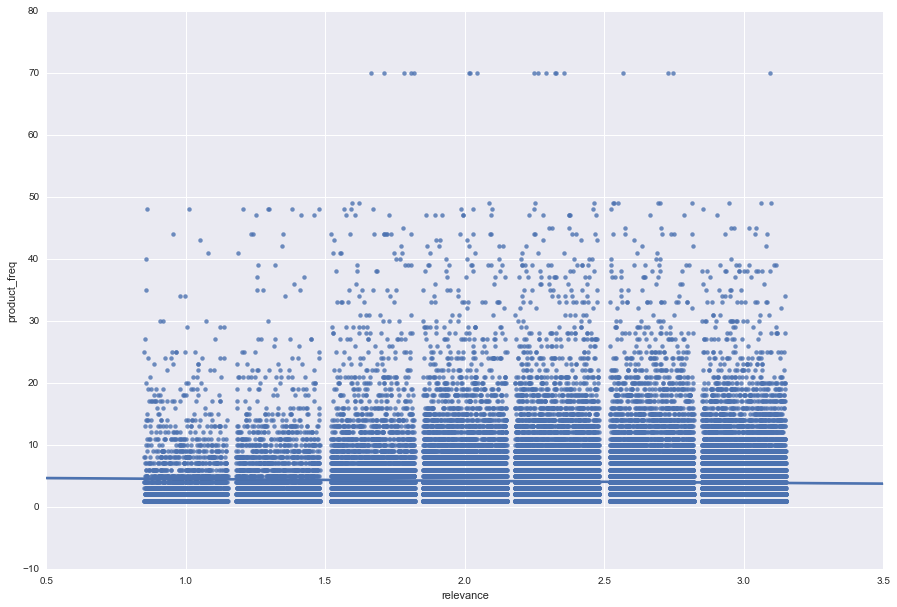

In [140]:
plt.figure(figsize=(15, 10))
sns.regplot(x="relevance", y="product_freq", data=df_train, x_jitter=.15);

## len of query

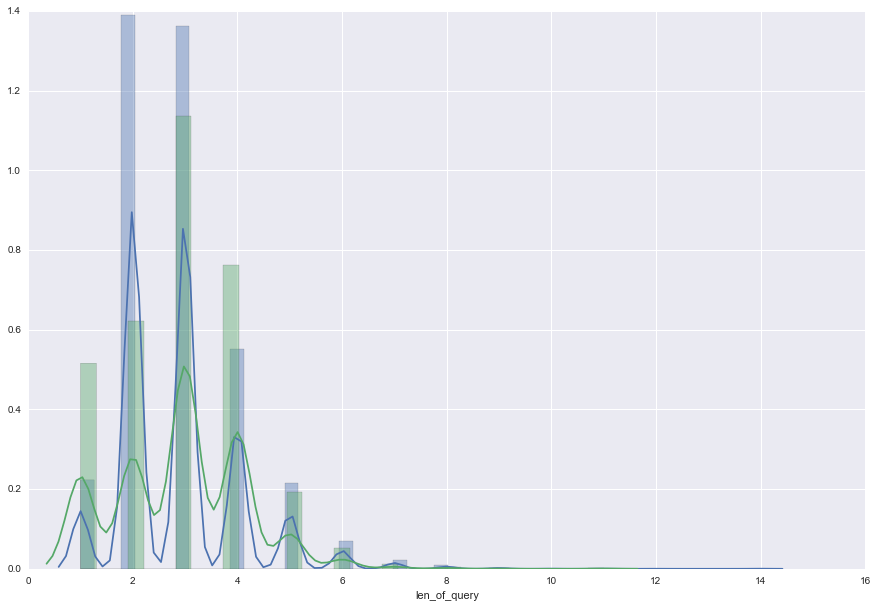

In [141]:
plt.figure(figsize=(15, 10))
#sns.plt.xlim(0, 0.6)
a = sns.distplot(df_train[df_train.relevance == 3.0].len_of_query)
b = sns.distplot(df_train[df_train.relevance == 1.0].len_of_query)

## query in title

In [142]:
#df_train.query_in_title

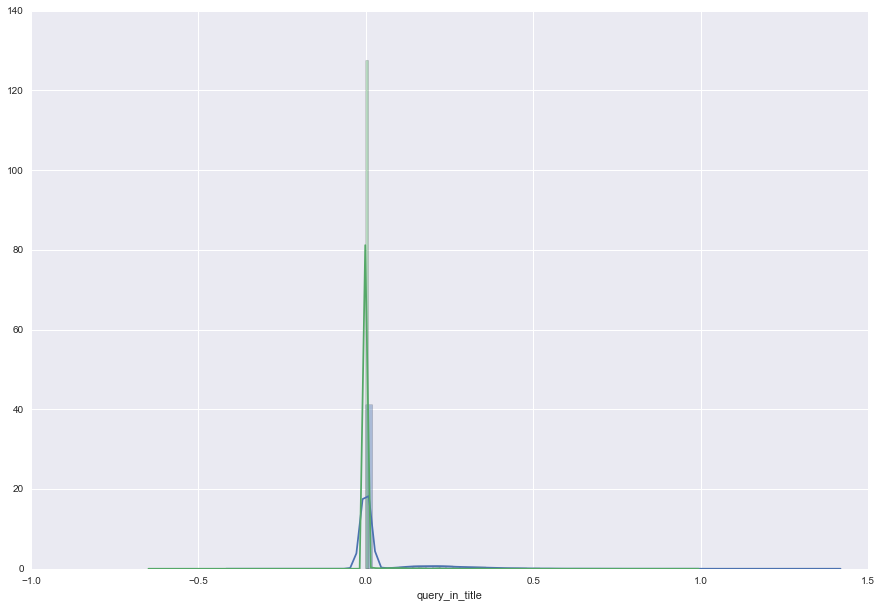

In [143]:
plt.figure(figsize=(15, 10))
#sns.plt.xlim(0, 0.6)
a = sns.distplot(df_train[df_train.relevance == 3.0].query_in_title)
b = sns.distplot(df_train[df_train.relevance == 1.0].query_in_title)